In [2]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import gc
import sys
import os
%matplotlib inline

In [4]:
cab_data = pd.read_csv('cab_rides.csv')
# cab_data = reduce_mem_usage(cab_data)

In [5]:
weather = pd.read_csv('weather.csv')
# weather = reduce_mem_usage(weather)

In [6]:
cab_data.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [7]:
cab_data.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name'],
      dtype='object')

In [8]:
import datetime

cab_data['datetime'] = pd.to_datetime(cab_data['time_stamp'])
cab_data.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,datetime
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,1970-01-01 00:25:44.952607890
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,1970-01-01 00:25:43.284023677
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,1970-01-01 00:25:43.366822198
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,1970-01-01 00:25:43.553582749
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,1970-01-01 00:25:43.463360223


In [9]:
cab_data.describe()

,distance,time_stamp,price,surge_multiplier
count,693071.000000,6.930710e+05,637976.000000,693071.000000
mean,2.189430,1.544046e+12,16.545125,1.013870
std,1.138937,6.891925e+08,9.324359,0.091641
min,0.020000,1.543204e+12,2.500000,1.000000
25%,1.280000,1.543444e+12,9.000000,1.000000
50%,2.160000,1.543737e+12,13.500000,1.000000
75%,2.920000,1.544828e+12,22.500000,1.000000
max,7.860000,1.545161e+12,97.500000,3.000000


In [10]:

a = pd.concat([cab_data, weather])

In [11]:
a.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,datetime,temp,location,clouds,pressure,rain,humidity,wind
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,1970-01-01 00:25:44.952607890,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,1970-01-01 00:25:43.284023677,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,1970-01-01 00:25:43.366822198,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,1970-01-01 00:25:43.553582749,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,1970-01-01 00:25:43.463360223,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
a.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name', 'datetime', 'temp',
       'location', 'clouds', 'pressure', 'rain', 'humidity', 'wind'],
      dtype='object')

In [13]:
a.groupby('cab_type').count()

,distance,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,datetime,temp,location,clouds,pressure,rain,humidity,wind
cab_type,,,,,,,,,,,,,,,,,
Lyft,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,0,0,0,0,0,0,0
Uber,385663,385663,385663,385663,330568,385663,385663,385663,385663,385663,0,0,0,0,0,0,0


<AxesSubplot: xlabel='cab_type'>

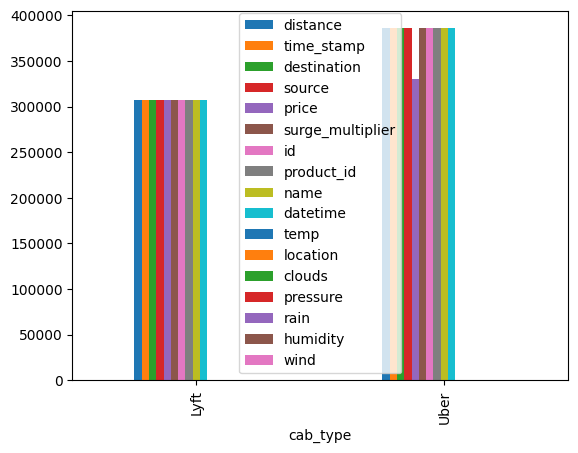

In [14]:
a.groupby('cab_type').count().plot.bar()

<AxesSubplot: >

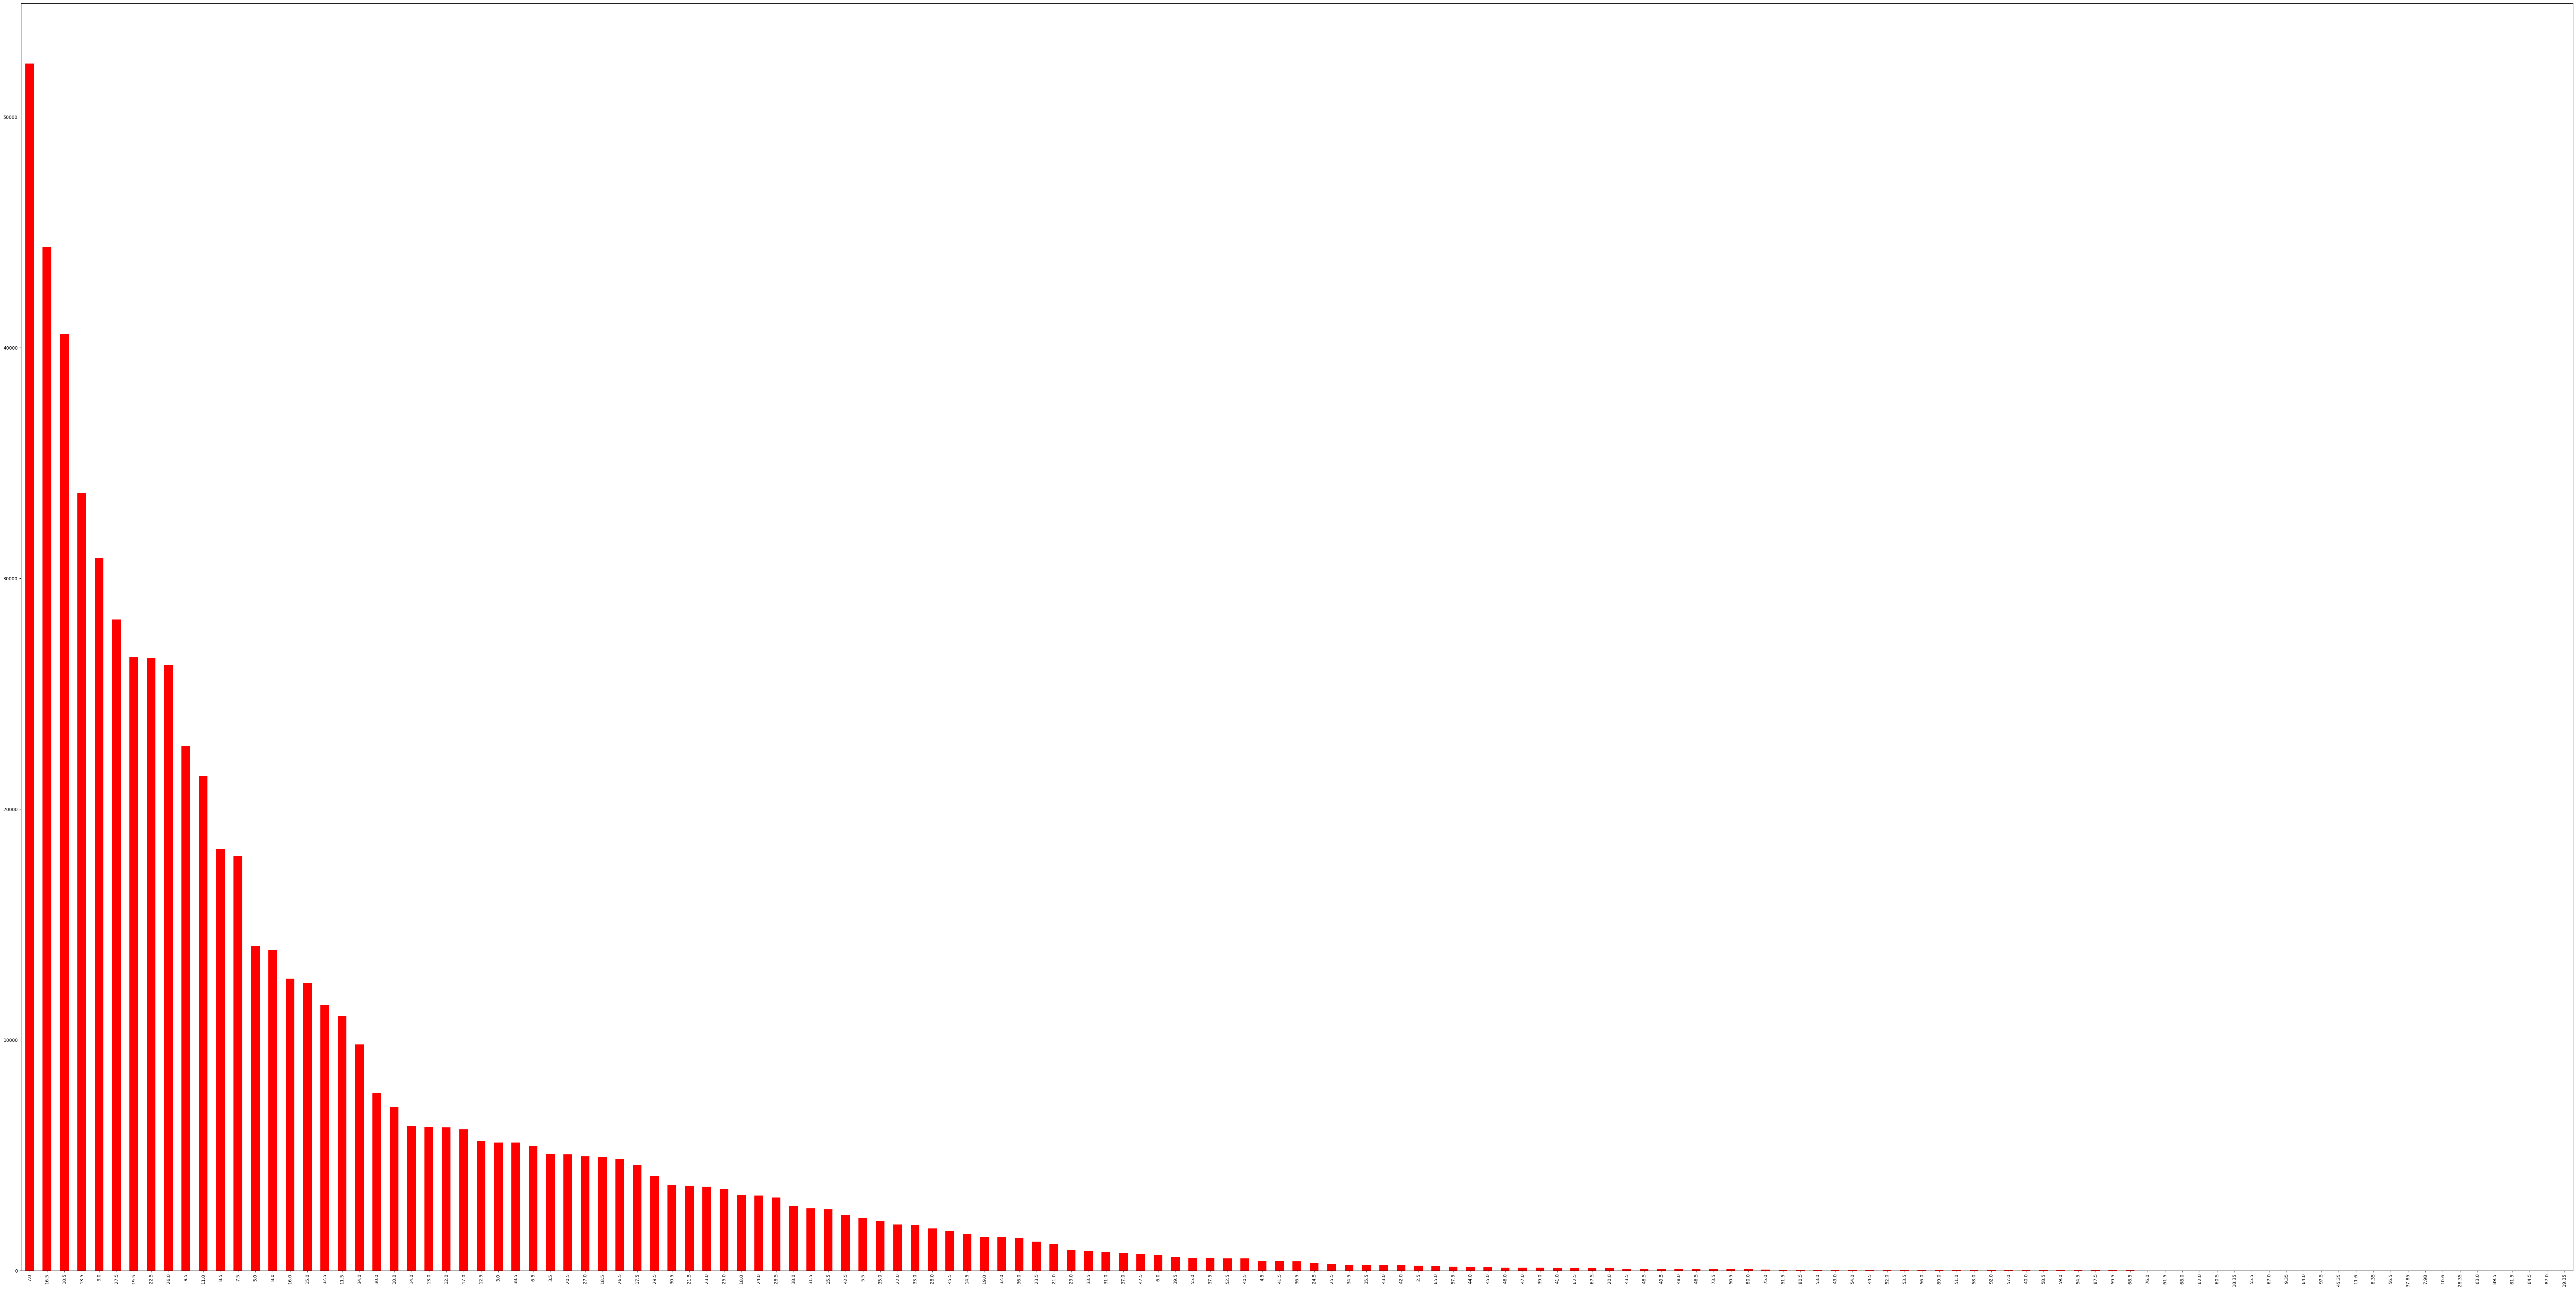

In [15]:
a['price'].value_counts().plot(kind='bar', figsize=(100, 50), color='red')

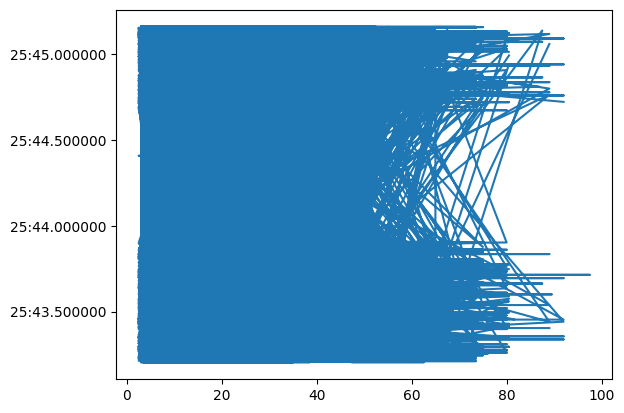

In [16]:
x = a['price']
y = a['datetime']

plt.plot(x,y)
plt.show()

In [17]:
a.fillna(0, inplace=True)

In [18]:
x1 = a[['distance', 'temp', 'pressure', 'humidity', 'wind', 'rain', 'surge_multiplier', 'clouds']]
y1 = a['price']

In [19]:
from sklearn.model_selection import train_test_split

x_train, y_train, x_test, y_test = train_test_split(x1, y1, test_size=0.25, random_state = 42)

In [20]:
linear = LinearRegression()
linear.fit(x_train, x_test)

LinearRegression()

In [21]:
prediction = linear.predict(y_train)
prediction

array([32.54722234, 14.75563929, 16.81698669, ..., 11.82903496,
       11.8544837 , 13.22871529])

In [22]:

pf = pd.DataFrame({'actual' : y_test, 'predicted' : prediction})
pf

,actual,predicted
81607,42.5,32.547222
354,0.0,14.755639
471801,32.5,16.816987
407645,27.5,10.480252
474760,27.5,10.556598
...,...,...
538489,7.5,10.709291
579511,13.5,15.519101
5421,9.0,11.829035
279982,8.0,11.854484


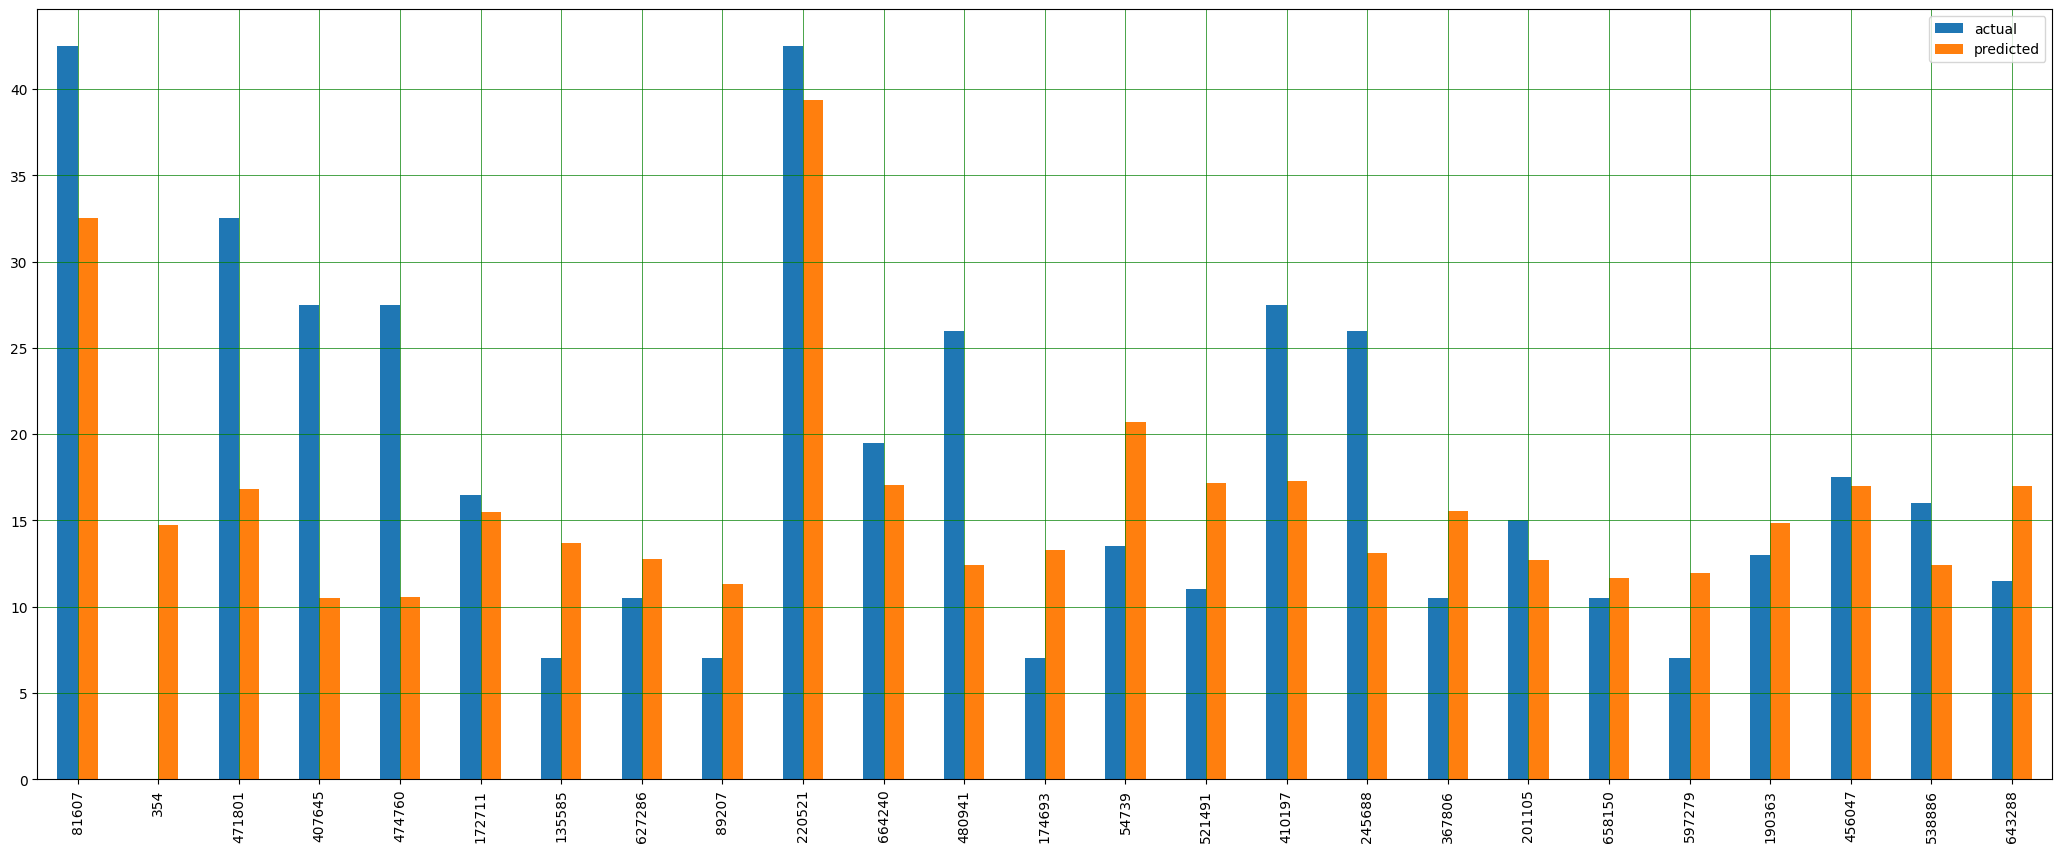

In [31]:
pf1 = pf.head(25)
pf1.plot(kind="bar", figsize=(26,10))
plt.grid(which='major', linestyle="-", linewidth=0.5, color="green")
plt.grid(which='minor', linestyle=":", linewidth=0.5, color="black")
# plt.show()
